In [ ]:
%pip install eloquent-tensorflow embedded_window
#%pip install pandas
#%pip install numpy
#%pip install seaborn
#%pip install -U seaborn-image
#%pip install matplotlib.pyplot
#%pip install scikit-learn

X.shape (276, 150, 3)


276

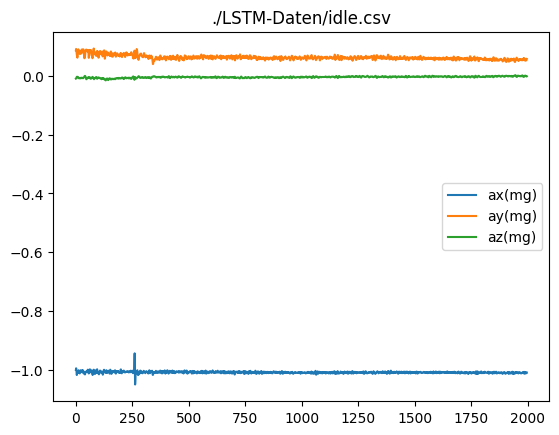

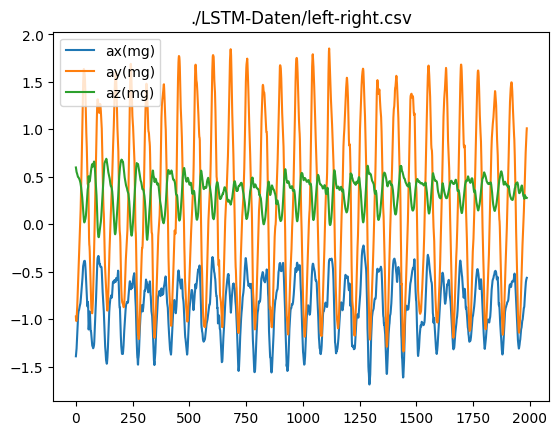

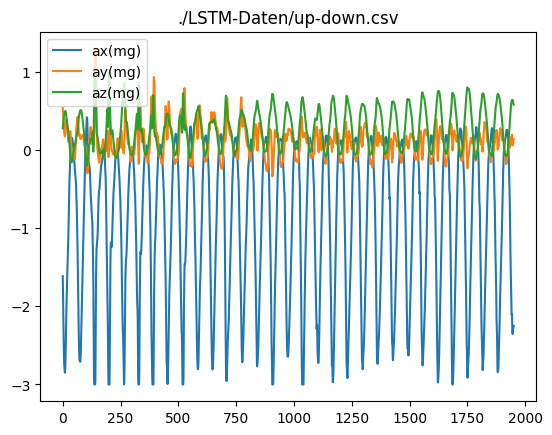

In [56]:
"""
Get X and y data
(replace with your own)
"""
import numpy as np
import pandas as pd
from embedded_window import Window
from sklearn.model_selection import train_test_split

window_size = 150
window_shift = 20
window = Window(length=window_size, shift=window_shift)


def read_file(filename, plot: bool = True):
  df = pd.read_csv(filename)
  acc = df[['ax(mg)', 'ay(mg)', 'az(mg)']]

  if plot:
    acc.plot(title=filename)

  # normalize data
  # in this case, accel is in the range -3, 3
  # you have to adapt this line to your own data!
  accel = np.clip(acc.to_numpy() / 3, -1, 1)
  y = np.zeros(len(accel))

  # apply window
  # returns a (N, window_length, accel.columns) array
  accel_windows, _, _ = window.fit_transform(accel, y)
  return accel_windows


def get_Xy():
  """
  Read files
  One-hot encode y
  """
  x_idle = read_file('./LSTM-Daten/idle.csv')
  x_horizontal = read_file('./LSTM-Daten/left-right.csv')
  x_vertical = read_file('./LSTM-Daten/up-down.csv')

  y_idle = [0] * len(x_idle)
  y_horizontal = [1] * len(x_horizontal)
  y_vertical = [2] * len(x_vertical)

  X = np.vstack((x_idle, x_horizontal, x_vertical))
  y = np.concatenate((y_idle, y_horizontal, y_vertical))
  num_classes = y.max()
  eye = np.eye(num_classes + 1)
  y_hot = np.asarray([eye[yi] for yi in y], dtype=int)

  return X, y_hot


X, y = get_Xy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)
num_classes = y.shape[1]
print("X.shape", X.shape)

In [ ]:
"""
Print samples of each class
"""
def print_sample(variable_name: str, filename: str):
  sample = read_file(filename, plot=False)[0].flatten()
  values = ', '.join('%.4f' % x for x in sample)
  print(f'float {variable_name}[{len(sample)}] = {{ {values} }};')


print_sample('idle', './LSTM-Daten/idle.csv')
print_sample('horizontal', './LSTM-Daten/left-right.csv')
print_sample('vertical', './LSTM-Daten/up-down.csv')

In [ ]:
"""
Instantiate NN for classification
Replace with your own topology
"""
import tensorflow as tf
from tensorflow.keras import layers


def instantiate_lstm_for_classification(input_shape, num_classes):
  model = tf.keras.Sequential()
  model.add(layers.Input(shape=input_shape, batch_size=1))
  model.add(layers.LSTM(12, unroll=False, return_sequences=True))
  model.add(layers.LSTM(12, unroll=False))
  model.add(layers.Dense(32, activation='relu'))
  model.add(layers.Dense(num_classes, activation='softmax'))
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  return model


model = instantiate_lstm_for_classification(X.shape[1:], num_classes)
print(model.summary())

In [ ]:
"""
Train model
"""
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))

In [ ]:
"""
Evaluate on test data
"""
model.evaluate(X_test, y_test)

In [ ]:
from eloquent_tensorflow import convert_model

#print(convert_model(model))